In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import other needed packages and functions
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
import lightgbm
from sklearn.model_selection import cross_val_score
import itertools


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
# read in csv files and make dfs
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

# make copy of test df for submission
submission = test_df.copy()

# combine train and test dfs into 1 df of all data
all_df = pd.concat([train_df, test_df], sort=False)

In [3]:
# Define function to inspect data frames. Prints first few lines, determines size/shape of data frame,
# shows descriptive statistics, shows data types, shows missing or incomplete data, check for duplicate data.

def inspect_df(df):
    print('Header:')
    print('{}'.format(df.head()))
    print()
    print('Shape: {}'.format(df.shape))
    print()
    print('Statistics:')
    print('{}'.format(df.describe()))
    print()
    print('Info:')
    print('{}'.format(df.info()))
    
# use inspect_df on all_df

inspect_df(all_df)

Header:
   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN      

In [4]:
# look at proportions of passengers by Pclass

all_df.Pclass.value_counts(normalize=True, sort=False)

1    0.246753
2    0.211612
3    0.541635
Name: Pclass, dtype: float64

In [5]:
# look at proportions of passengers by Sex

all_df.Sex.value_counts(normalize=True)

male      0.644003
female    0.355997
Name: Sex, dtype: float64

In [6]:
# inspect null values for Embarked

all_df[all_df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Looked up Mrs. Stone and Miss Icard online, they boarded in Southampton.

In [7]:
# fill missing values for Embarked with information found online

all_df.loc[[61, 829], ['Embarked']] = 'S'

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


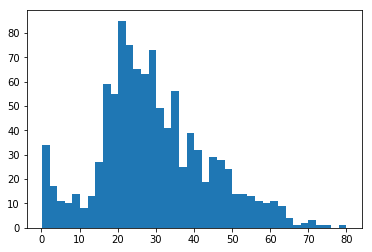

In [8]:
# plot histogram of Ages

plt.hist(data = all_df, x = 'Age', bins = 40);

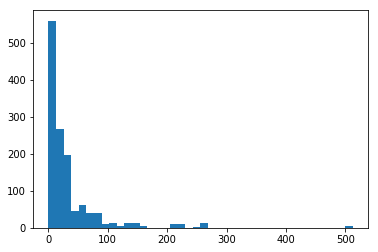

In [9]:
# plot histogram of Fare

plt.hist(data = all_df, x = 'Fare', bins = 40);

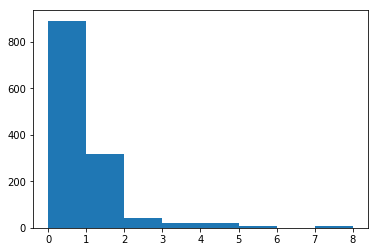

In [10]:
# plot histogram of siblings and spouses

plt.hist(data = all_df, x = 'SibSp', bins = 8);

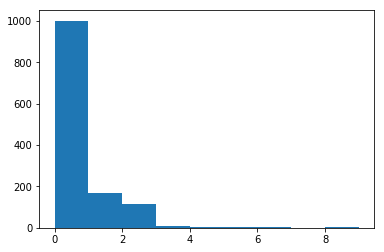

In [11]:
# plot histogram of parents and children

plt.hist(data = all_df, x = 'Parch', bins = 9);

In [12]:
# inspect columns and missing values again

all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 172.9+ KB


In [13]:
# find passenger with missing fare data

all_df[all_df.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [14]:
# get average fare of each Pclass

all_df.Fare.groupby(all_df.Pclass).mean()

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [15]:
#fill nan fare value with rounded mean for class 3

all_df.loc[152, ['Fare']] = 13

In [16]:
# fill missing values for ages with the mean age value for each passengers Pclass and Sex

all_df.Age = all_df.Age.groupby([all_df.Pclass, all_df.Sex]).transform(lambda x: x.fillna(x.mean()))

In [17]:
# Extract titles from names and make new Title column, then get survival rate of each title

all_df['Title'] = all_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
all_df.Survived.groupby(all_df.Title).mean()

Title
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dona             NaN
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64

In [18]:
# get value counts for title occurences

all_df.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Mlle          2
Ms            2
Sir           1
Don           1
Lady          1
Mme           1
Dona          1
Jonkheer      1
Capt          1
Countess      1
Name: Title, dtype: int64

In [19]:
# Replace uncommon titles with more common values and view new occurences

all_df.Title = all_df.Title.replace(['Capt', 'Col', 'Dr', 'Major', 'Rev', 'Don', 'Sir', 'Jonkheer'], 'Mr')
all_df.Title = all_df.Title.replace(['Ms', 'Mlle'], 'Miss')
all_df.Title = all_df.Title.replace(['Mme', 'Lady', 'Countess', 'Dona'], 'Mrs')
all_df.Title.value_counts()

Mr        783
Miss      264
Mrs       201
Master     61
Name: Title, dtype: int64

In [20]:
# combine sibsp and parch to one family column
all_df['Fam'] = all_df.SibSp + all_df.Parch

# make ticket frequency column for number of occurences of ticket number
all_df['Ticket_Frequency'] = all_df.groupby('Ticket')['Ticket'].transform('count')
    
# make column for solo vs travel with family
all_df.loc[all_df['Fam'] == 0, 'Solo'] = 1
all_df.loc[all_df['Ticket_Frequency'] == 1, 'Solo'] = 1
all_df.Solo = all_df.Solo.fillna(0)
       
# bin fare column to 9 quantiles and encode as ordinal
all_df['Fare'] = pd.qcut(all_df.Fare, q=9, labels=np.arange(1,10))
    
# bin age column to 10 quantiles and encode as ordinal
all_df['Age'] = pd.qcut(all_df.Age, q=10, labels=np.arange(1,11))
    
# one-hot encode sex column and capitalize sex columns for consistency
all_df = pd.concat([all_df, pd.get_dummies(all_df.Sex)], axis=1)
all_df.rename(columns={'male':'Male', 'female':'Female'}, inplace=True)
    
# one-hot encode embarked column
all_df = pd.concat([all_df, pd.get_dummies(all_df.Embarked, prefix='Embarked')], axis=1)
    
# one-hot encode title column
all_df = pd.concat([all_df, pd.get_dummies(all_df.Title)], axis=1)
    
# drop unwanted columns (name, sex, cabin, embarked and title have been replaced with one hot encoding, ticket replaced with ticket frequency,
# cabin has too many missing values, sibsp and parch replaced with fam and solo columns)
all_df = all_df.drop(columns=['Name', 'Sex', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked', 'Title'])
    
# inspect columns and number of values for resulting df
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 17 columns):
PassengerId         1309 non-null int64
Survived            891 non-null float64
Pclass              1309 non-null int64
Age                 1309 non-null category
Fare                1309 non-null category
Fam                 1309 non-null int64
Ticket_Frequency    1309 non-null int64
Solo                1309 non-null float64
Female              1309 non-null uint8
Male                1309 non-null uint8
Embarked_C          1309 non-null uint8
Embarked_Q          1309 non-null uint8
Embarked_S          1309 non-null uint8
Master              1309 non-null uint8
Miss                1309 non-null uint8
Mr                  1309 non-null uint8
Mrs                 1309 non-null uint8
dtypes: category(2), float64(2), int64(4), uint8(9)
memory usage: 86.4 KB


In [21]:
# inspect survival rates for number of family members onboard

all_df.Survived.groupby(all_df.Fam).mean()

Fam
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

In [22]:
# bin fam column values and get value counts

all_df.Fam = pd.cut(all_df.Fam, bins=[0, 1, 4, 7, 11], include_lowest=True, right=False, labels=[1, 2, 3, 4])
all_df.Fam.value_counts()

1    790
2    437
3     63
4     19
Name: Fam, dtype: int64

In [23]:
# inspect survival rate for number of people traveling in group

all_df.Survived.groupby(all_df.Ticket_Frequency).mean()

Ticket_Frequency
1     0.270270
2     0.513812
3     0.653465
4     0.727273
5     0.333333
6     0.210526
7     0.208333
8     0.384615
11    0.000000
Name: Survived, dtype: float64

In [24]:
# bin ticket frequency column values and get value counts

all_df.Ticket_Frequency = pd.cut(all_df.Ticket_Frequency, bins=[0, 2, 5, 9, 12], right=False, labels=[1, 2, 3, 4])
all_df.Ticket_Frequency.value_counts()

1    713
2    475
3    110
4     11
Name: Ticket_Frequency, dtype: int64

In [25]:
# make list of all columns and view it

cols = list(all_df)
cols

['PassengerId',
 'Survived',
 'Pclass',
 'Age',
 'Fare',
 'Fam',
 'Ticket_Frequency',
 'Solo',
 'Female',
 'Male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Master',
 'Miss',
 'Mr',
 'Mrs']

In [26]:
# use min max scaler to scale all feature columns to range 0-1

scaler = MinMaxScaler()
all_df[cols] = scaler.fit_transform(all_df[cols])

In [27]:
# make array of survived labels (training), drop survived column from all_df, split all_df into features (training) and test_df, and make array of feature column names

labels = all_df.loc[:890, 'Survived']
all_df = all_df.drop(columns = 'Survived')
features = all_df.iloc[:891]
test_df = all_df.iloc[891:]
feat_names = features.columns.values

In [28]:
# use SelectKBest to narrow down to top features and use result to transform train and test features dfs

k = SelectKBest(k=11)
k.fit(features, labels)
k_scores = (k.scores_)
features = k.transform(features)
test_df = k.transform(test_df)

In [29]:
# make df to show scores for all features and print

feat_scores = pd.DataFrame()
feat_scores['Feature'] = feat_names
feat_scores['Score'] = k_scores
feat_scores

,Feature,Score
0,PassengerId,0.022285
1,Pclass,115.031272
2,Age,0.118749
3,Fare,108.327062
4,Fam,6.313788
5,Ticket_Frequency,17.149390
6,Solo,47.368609
7,Female,372.405724
8,Male,372.405724
9,Embarked_C,25.895987


In [30]:
# split training data into train and test subsets for validation

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=3)

In [31]:
# setup base classifiers

gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
ab = AdaBoostClassifier()
dt = DecisionTreeClassifier()
lr = LogisticRegression(solver='liblinear')
kn = KNeighborsClassifier()
svc = SVC(gamma='auto', probability=True)
gnb = GaussianNB()

In [32]:
# get train base classifiers and get initial validation scores

gb.fit(features_train, labels_train)
print('GB Score:', gb.score(features_test, labels_test))
rf.fit(features_train, labels_train)
print('RF Score:', rf.score(features_test, labels_test))
et.fit(features_train, labels_train)
print('ET Score:', et.score(features_test, labels_test))
ab.fit(features_train, labels_train)
print('AB Score:', ab.score(features_test, labels_test))
dt.fit(features_train, labels_train)
print('DT Score:', dt.score(features_test, labels_test))
lr.fit(features_train, labels_train)
print('LR Score:', lr.score(features_test, labels_test))
kn.fit(features_train, labels_train)
print('KN Score:', kn.score(features_test, labels_test))
svc.fit(features_train, labels_train)
print('SVC Score:', svc.score(features_test, labels_test))
gnb.fit(features_train, labels_train)
print('GNB Score:', gnb.score(features_test, labels_test))

GB Score: 0.8156424581005587
RF Score: 0.8212290502793296
ET Score: 0.8156424581005587
AB Score: 0.8044692737430168
DT Score: 0.8156424581005587
LR Score: 0.8212290502793296
KN Score: 0.8044692737430168


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


SVC Score: 0.8044692737430168
GNB Score: 0.7821229050279329


In [33]:
# use gridsearch to tune base classifier hyperparameters

alg = gb
params = {'n_estimators': (10, 25, 50, 100), 'learning_rate': (0.01, 0.1, 0.5, 1, 5, 10)}
clf = GridSearchCV(alg, params, cv = 5, scoring = 'accuracy', n_jobs = -1)
clf.fit(features_train, labels_train)
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
gb = clf.best_estimator_

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 100}
Best Score: 0.8286516853932584


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [34]:
# use gridsearch to tune base classifier hyperparameters

alg = rf
params = {'n_estimators': (10, 25, 50, 100), 'min_samples_split': (2, 3, 4, 5, 10), 'min_samples_leaf': (1, 2, 3, 4, 5)}
clf = GridSearchCV(alg, params, cv = 5, scoring = 'accuracy', n_jobs = -1)
clf.fit(features_train, labels_train)
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
rf = clf.best_estimator_

Best Parameters: {'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 25}
Best Score: 0.8300561797752809


In [35]:
# use gridsearch to tune base classifier hyperparameters

alg = et
params = {'n_estimators': (10, 25, 50, 100), 'min_samples_split': (2, 3, 4, 5, 10), 'min_samples_leaf': (1, 2, 3, 4, 5)}
clf = GridSearchCV(alg, params, cv = 5, scoring = 'accuracy', n_jobs = -1)
clf.fit(features_train, labels_train)
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
et = clf.best_estimator_

Best Parameters: {'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10}
Best Score: 0.8370786516853933


In [36]:
# use gridsearch to tune base classifier hyperparameters

alg = ab
params = {'n_estimators': (10, 25, 50, 100), 'learning_rate': (0.01, 0.1, 0.5, 1, 5, 10)}
clf = GridSearchCV(alg, params, cv = 5, scoring = 'accuracy', n_jobs = -1)
clf.fit(features_train, labels_train)
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
ab = clf.best_estimator_

Best Parameters: {'learning_rate': 1, 'n_estimators': 10}
Best Score: 0.8146067415730337


In [37]:
# use gridsearch to tune base classifier hyperparameters

alg = dt
params = {'min_samples_split': (2, 3, 4, 5, 10), 'min_samples_leaf': (1, 2, 3, 4, 5)}
clf = GridSearchCV(alg, params, cv = 5, scoring = 'accuracy', n_jobs = -1)
clf.fit(features_train, labels_train)
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
dt = clf.best_estimator_

Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 4}
Best Score: 0.8174157303370787


In [38]:
# use gridsearch to tune base classifier hyperparameters

alg = lr
params = {'penalty': ('l1', 'l2'), 'C': (0.01, 0.1, 0.5, 1, 5, 10), 'max_iter': (100, 500)}
clf = GridSearchCV(alg, params, cv = 5, scoring = 'accuracy', n_jobs = -1)
clf.fit(features_train, labels_train)
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
lr = clf.best_estimator_

Best Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l1'}
Best Score: 0.8188202247191011


In [39]:
# use gridsearch to tune base classifier hyperparameters

alg = kn
params = {'n_neighbors': (2, 3, 4, 5, 10, 20)}
clf = GridSearchCV(alg, params, cv = 5, scoring = 'accuracy', n_jobs = -1)
clf.fit(features_train, labels_train)
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
kn = clf.best_estimator_

Best Parameters: {'n_neighbors': 10}
Best Score: 0.8117977528089888


In [40]:
# use gridsearch to tune base classifier hyperparameters

alg = svc
params = {'C': (0.01, 0.1, 0.5, 1, 5, 10), 'kernel': ('linear', 'poly', 'rbf', 'sigmoid')}
clf = GridSearchCV(alg, params, cv = 5, scoring = 'accuracy', n_jobs = -1)
clf.fit(features_train, labels_train)
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
svc = clf.best_estimator_

Best Parameters: {'C': 10, 'kernel': 'poly'}
Best Score: 0.824438202247191


In [41]:
# retrain base classifiers and get validation scores

gb.fit(features_train, labels_train)
print('GB Score:', gb.score(features_test, labels_test))
rf.fit(features_train, labels_train)
print('RF Score:', rf.score(features_test, labels_test))
et.fit(features_train, labels_train)
print('ET Score:', et.score(features_test, labels_test))
ab.fit(features_train, labels_train)
print('AB Score:', ab.score(features_test, labels_test))
dt.fit(features_train, labels_train)
print('DT Score:', dt.score(features_test, labels_test))
lr.fit(features_train, labels_train)
print('LR Score:', lr.score(features_test, labels_test))
kn.fit(features_train, labels_train)
print('KN Score:', kn.score(features_test, labels_test))
svc.fit(features_train, labels_train)
print('SVC Score:', svc.score(features_test, labels_test))
gnb.fit(features_train, labels_train)
print('GNB Score:', gnb.score(features_test, labels_test))

GB Score: 0.8379888268156425
RF Score: 0.8379888268156425
ET Score: 0.8212290502793296
AB Score: 0.7988826815642458
DT Score: 0.8156424581005587
LR Score: 0.8212290502793296
KN Score: 0.8324022346368715
SVC Score: 0.8379888268156425
GNB Score: 0.7821229050279329


In [42]:
# setup voting classifier and get initial cross val score

vote = VotingClassifier(estimators=[('gb',gb), ('rf',rf), ('et',et), ('ab',ab), ('dt',dt), ('lr',lr), ('kn',kn), ('svc',svc), ('gnb',gnb)], voting='soft')
vote.fit(features, labels)
cross_val_score(vote, features, labels, cv=5, scoring='accuracy').mean()

0.8283140889719685

In [43]:
# retrain voting classifier and get validation score

vote.fit(features_train, labels_train)
print('Voting Score:', vote.score(features_test, labels_test))

Voting Score: 0.8324022346368715


In [44]:
# use itertools combinations to make list of tuples of all possible different combinations of classifiers

clfs = [('gb',gb), ('rf',rf), ('et',et), ('ab',ab), ('dt',dt), ('lr',lr), ('kn',kn), ('svc',svc), ('gnb',gnb)]
combs = []

for i in range(2, len(clfs)+1):
    comb = [list(x) for x in itertools.combinations(clfs, i)]
    combs.extend(comb)

In [45]:
# Tune voting classifier to use best combination of base classifiers

alg = vote
params = {'estimators': combs}
clf = GridSearchCV(alg, params, cv = 5, scoring = 'accuracy', n_jobs = -1)
clf.fit(features, labels)
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
vote = clf.best_estimator_

Best Parameters: {'estimators': [('gb', GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5,

In [46]:
# retrain voting classifier and get validation score

vote.fit(features_train, labels_train)
print('Voting Score:', vote.score(features_test, labels_test))

Voting Score: 0.8324022346368715


In [47]:
# retrain voting classifier with full train set, use to make probability predictions and make df of probs, set threshold for probablities and use to convert probs to predictions

vote.fit(features, labels)
pred_prob = pd.DataFrame(vote.predict_proba(test_df))
threshold = 0.55
y_pred = pred_prob.applymap(lambda x: 1 if x>threshold else 0)

In [48]:
# add predictions submission df as survived column, drop all columns but passenger ID and survived, write submission to csv without index to generate submission file

submission['Survived'] = y_pred[1].astype(int)
submission = submission[['PassengerId', 'Survived']]
submission.to_csv('submission.csv', index=False)